# Loading dataset 
___

- Datasets can be found at: https://opendatasus.saude.gov.br/dataset 
- Search for "Síndrome respiratória aguda grave"

In [1]:
import pandas as pd

In [2]:
srag21 = pd.read_csv('SRAG_2021.csv', delimiter=';', dtype=str)
srag21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733517 entries, 0 to 1733516
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.1+ GB


In [3]:
srag22 = pd.read_csv('SRAG_2022.csv', delimiter=';', dtype=str)
srag22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542162 entries, 0 to 542161
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 686.6+ MB


In [4]:
df = pd.concat([srag21, srag22])
df.index = pd.RangeIndex(start=0, stop=len(df.index))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275679 entries, 0 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.8+ GB


# Data Wrangling and Exploratory Data Analysis
___

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
# Selecting data starting on July 1, 2021 to balance the number of vaccinated people
start_date = datetime(year=2021, month=7, day=1)
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], format='%d/%m/%Y')
df = df[df['DT_SIN_PRI'] >= start_date].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978220 entries, 90 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 1.2+ GB


In [7]:
# Including only confirmed COVID-19 cases
df = df[df['CLASSI_FIN'] == '5'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426366 entries, 8354 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 543.2+ MB


In [8]:
# Including only cases that were confirmed hospitalizations
df = df[df['HOSPITAL'] == '1'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410959 entries, 8354 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 523.6+ MB


## Target Variable: Death

In [9]:
df = df[(pd.notna(df['EVOLUCAO'])) &
        (df['EVOLUCAO'] != '3') &
        (df['EVOLUCAO'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372460 entries, 8354 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 474.6+ MB


In [10]:
df['EVOLUCAO'].value_counts()

1    265222
2    107238
Name: EVOLUCAO, dtype: int64

In [11]:
df['death'] = df['EVOLUCAO'].apply(lambda x: 1 if x == '2' else 0)
df['death'].value_counts()

0    265222
1    107238
Name: death, dtype: int64

## Demographics

### Age

In [12]:
# Converting age to numerical values
df['age'] = pd.to_numeric(df['NU_IDADE_N'])
print(df['age'].min())
print(df['age'].max())

-9
118


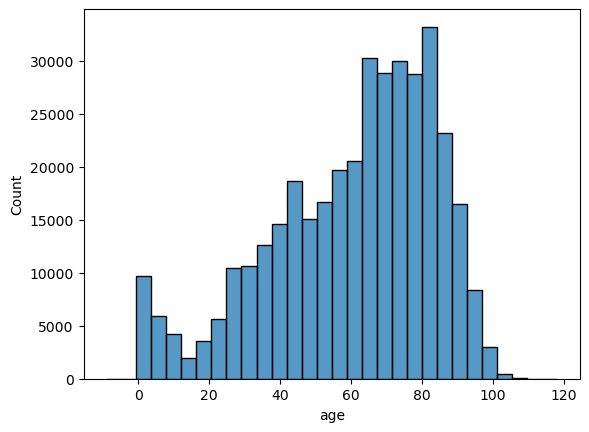

In [13]:
sns.histplot(data=df, x='age', bins=30);

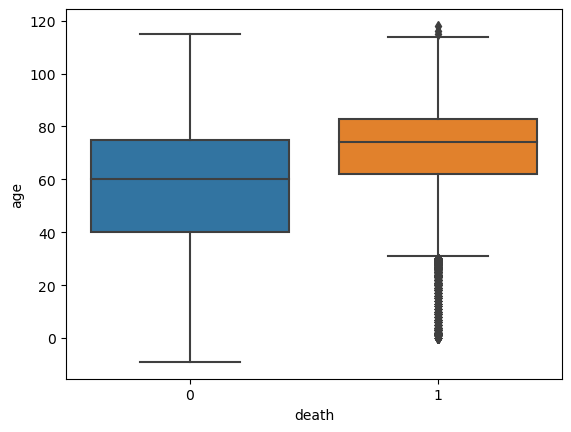

In [14]:
sns.boxplot(data=df, x='death', y='age');

In [15]:
# Age percentiles
q1, q2, q3 = np.percentile(df['age'], [25, 50, 75])
print(f'q1: {q1}')
print(f'q2: {q2}')
print(f'q3: {q3}')
iqr = q3 - q1
print(f'iqr: {iqr}')

q1: 45.0
q2: 65.0
q3: 78.0
iqr: 33.0


In [16]:
# Filtering age
df = df[(df['age'] >= 18) & # only adults
        (df['age'] <= 110)].copy() # removing age outliers
df['age'].describe()

count    349890.000000
mean         63.906468
std          19.228001
min          18.000000
25%          50.000000
50%          67.000000
75%          79.000000
max         110.000000
Name: age, dtype: float64

In [17]:
df.groupby(['death'])['age'].mean()

death
0    60.596684
1    71.492793
Name: age, dtype: float64

### Sex

In [18]:
df['CS_SEXO'].value_counts()

M    183616
F    166247
I        27
Name: CS_SEXO, dtype: int64

In [19]:
# Removing ignored answers 
df = df[df['CS_SEXO'] != 'I'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349863 entries, 8354 to 2275678
Columns: 168 entries, DT_NOTIFIC to age
dtypes: datetime64[ns](1), int64(2), object(165)
memory usage: 451.1+ MB


In [20]:
df['male'] = df['CS_SEXO'].apply(lambda x: 1 if x == 'M' else 0)
df['male'].value_counts()

1    183616
0    166247
Name: male, dtype: int64

### Race

In [21]:
df['CS_RACA'].value_counts()

1    166440
4    108299
9     57255
2     13873
3      3437
5       559
Name: CS_RACA, dtype: int64

In [22]:
race_dict = {'1': 'white', '2': 'black',
             '3': 'asian', '4': 'mixed',
             '5': 'indigenous', '9': 'n/a'}
df['race'] = df['CS_RACA'].apply(lambda x: race_dict.get(x))
df['race'] = df['race'].apply(lambda x: 'n/a' if pd.isna(x) else x)
df = df[df['race'] != 'n/a'].copy()
df['race'].value_counts()

white         166440
mixed         108299
black          13873
asian           3437
indigenous       559
Name: race, dtype: int64

### Education

In [23]:
df['CS_ESCOL_N'].value_counts()

9    76802
1    36198
3    33052
2    21745
4    14586
0    10316
5       39
Name: CS_ESCOL_N, dtype: int64

In [24]:
ed_dict = {'0': 'illiterate', 
               '1': '5_grade', 
               '2': '9_grade', 
               '3': '12_grade', 
               '4': 'higher_ed',
               '5': 'n/a',
               '9': 'n/a'}
df['education'] = df['CS_ESCOL_N'].apply(lambda x: ed_dict.get(x))
df['education'] = df['education'].apply(lambda x: 'n/a' if pd.isna(x) else x)
df = df[df['education'] != 'n/a'].copy()
school_cat = ['illiterate', '5_grade', 
          '9_grade', '12_grade', 'higher_ed']
df['education'] = pd.Categorical(df['education'], categories=school_cat)
df['education'].value_counts().sort_index()

illiterate    10316
5_grade       36198
9_grade       21745
12_grade      33052
higher_ed     14586
Name: education, dtype: int64

## Vaccination Status

In [27]:
# 1 = Vaccinated
# 2 = Unvaccinated
vaccination_dict = {'1': 'vaccinated', 
                    '2': 'unvaccinated', 
                    '9': 'n/a'}
df['vaccination_status'] = df['VACINA_COV'].apply(lambda x: vaccination_dict.get(x))
df['vaccination_status'].value_counts()

vaccinated      81546
unvaccinated    27220
n/a              5229
Name: vaccination_status, dtype: int64

In [28]:
df['first_dose'] = df['DOSE_1_COV'].apply(lambda x: 'n/a' if pd.isna(x) else 'yes')
df['first_dose'].value_counts()

yes    73997
n/a    41900
Name: first_dose, dtype: int64

In [29]:
df.groupby(['vaccination_status', 'first_dose'])['age'].count()

vaccination_status  first_dose
n/a                 n/a            5201
                    yes              28
unvaccinated        n/a           27156
                    yes              64
vaccinated          n/a            7654
                    yes           73892
Name: age, dtype: int64

- There are vaccinated patients with no date of first_dose 
- There are unvaccinated patients with date of first_dose 

In [30]:
df['second_dose'] = df['DOSE_2_COV'].apply(lambda x: 'n/a' if pd.isna(x) else 'yes')
df['second_dose'].value_counts()

yes    62253
n/a    53644
Name: second_dose, dtype: int64

In [31]:
df.groupby(['first_dose', 'second_dose'])['age'].count()

first_dose  second_dose
n/a         n/a            40598
            yes             1302
yes         n/a            13046
            yes            60951
Name: age, dtype: int64

- There are patients with date of second_dose without date of first_dose

In [32]:
df['booster'] = df['DOSE_REF'].apply(lambda x: 'n/a' if pd.isna(x) else 'yes')
df['booster'].value_counts()

n/a    95057
yes    20840
Name: booster, dtype: int64

In [33]:
df.groupby(['second_dose', 'booster'])['age'].count()

second_dose  booster
n/a          n/a        52968
             yes          676
yes          n/a        42089
             yes        20164
Name: age, dtype: int64

- There are patients with date of booster without date of second_dose

In [35]:
df['FAB_COV_1'].value_counts().head(20)

86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        21992
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD    15437
CORONAVAC                                          6419
BUTANTAN                                           4431
87 - COVID-19 PFIZER - COMIRNATY                   3943
ASTRAZENECA                                        3594
FIOCRUZ                                            1987
PFIZER                                             1819
ASTRAZENICA                                        1411
SINOVAC/BUTANTAN                                    943
86 - COVID-19-CORONAVAC-SINOVAC/BUTANTAN            820
89 - COVID-19 ASTRAZENECA - CHADOX1-S               695
SINOVAC                                             637
OXFORD/FIOCRUZ                                      566
OXFORD                                              565
ASTRAZENECA/OXFORD/FIOCRUZ                          505
FIO CRUZ                                            407
JANSSEN                                         

In [36]:
df['FAB_COV_2'].value_counts().head(20)

86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        16254
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD    10488
87 - COVID-19 PFIZER - COMIRNATY                   2246
89 - COVID-19 ASTRAZENECA - CHADOX1-S               963
CORONAVAC                                           547
BUTANTAN                                            292
ASTRAZENECA                                         245
PFIZER                                              139
FIOCRUZ                                             138
INSTITUTO BUTANTAN                                   92
SINOVAC/BUTANTAN                                     89
ASTRAZENICA                                          76
SINOVAC                                              59
ASTRAZENECA/OXFORD/FIOCRUZ                           56
FUNDACAO OSWALDO CRUZ                                49
VACINA COVID-19 BUTANTAN                             48
ASTRAZENECA/FIOCRUZ                                  32
FIO CRUZ                                        

In [37]:
df['FAB_COVREF'].value_counts().head(20)

87 - COVID-19 PFIZER - COMIRNATY                  14470
86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC         2370
88 - COVID-19 JANSSEN - AD26.COV2.S                1312
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD     1297
PFIZER                                              755
CORONAVAC                                           172
PFIZER MANUFACTURING BELGIUM NV - BELGICA            68
JANSSEN                                              29
VACINA COVID-19 PFIZER                               24
SINOVAC                                              22
ASTRAZENECA                                          22
SINOVAC/BUTANTAN                                     21
VACINA COVID-19-RNAM, PFIZER (COMIRNATY)             12
BUTANTAN                                             10
FIOCRUZ                                              10
ASTRAZENECA/OXFORD/FIOCRUZ                            8
PFAIZER                                               7
ASTRAZENICA                                     

## Comorbidities

### Obesity 

In [38]:
df['OBESIDADE'].value_counts()

2    50017
1     9509
9      810
Name: OBESIDADE, dtype: int64

In [39]:
df = df[(pd.notna(df['OBESIDADE'])) &
        (df['OBESIDADE'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59526 entries, 8459 to 2275666
Columns: 175 entries, DT_NOTIFIC to booster
dtypes: category(1), datetime64[ns](1), int64(3), object(170)
memory usage: 79.5+ MB


In [40]:
df['obesity'] = df['OBESIDADE'].apply(lambda x: 1 if x == '1' else 0)
df['obesity'].value_counts()

0    50017
1     9509
Name: obesity, dtype: int64

### BMI

In [41]:
df['bmi'] = df['OBES_IMC'].str.replace(',', '.')
df['bmi'] = pd.to_numeric(df['bmi'])
df['bmi'].describe()

count    1938.000000
mean       30.306605
std        16.173835
min         0.000000
25%        29.625000
50%        32.800000
75%        37.975000
max       329.000000
Name: bmi, dtype: float64

In [42]:
df.groupby(['obesity'])['bmi'].mean()
# BMI is only filled out for patients with obesity

obesity
0          NaN
1    30.306605
Name: bmi, dtype: float64

In [43]:
df.groupby(['death'])['bmi'].mean()

death
0    30.290288
1    30.341290
Name: bmi, dtype: float64

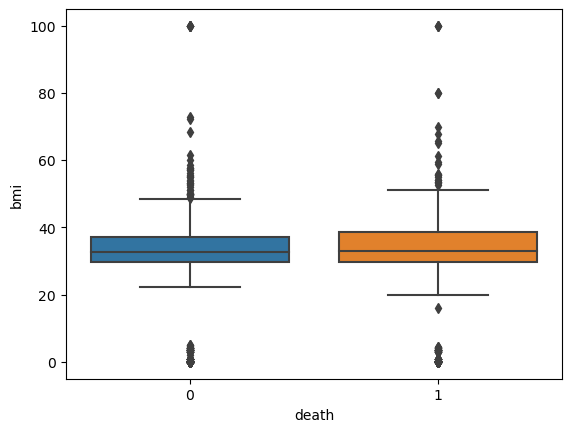

In [44]:
sns.boxplot(data=df[df['bmi'] < 100], x='death', y='bmi');

### Diabetes

In [45]:
df['DIABETES'].value_counts()

2    36452
1    21385
9       74
Name: DIABETES, dtype: int64

In [46]:
# Removing missing values
df = df[(pd.notna(df['DIABETES'])) &
        (df['DIABETES'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57837 entries, 8459 to 2275666
Columns: 177 entries, DT_NOTIFIC to bmi
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(170)
memory usage: 78.2+ MB


In [47]:
df['diabetes'] = df['DIABETES'].apply(lambda x: 1 if x == '1' else 0)
df['diabetes'].value_counts()

0    36452
1    21385
Name: diabetes, dtype: int64

In [48]:
df.groupby('diabetes')['death'].value_counts(normalize=True).unstack()

death,0,1
diabetes,,
0,0.639444,0.360556
1,0.601450,0.398550


### Heart disease

In [49]:
# Removing missing values
df = df[(pd.notna(df['CARDIOPATI'])) &
        (df['CARDIOPATI'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57364 entries, 8459 to 2275666
Columns: 178 entries, DT_NOTIFIC to diabetes
dtypes: category(1), datetime64[ns](1), float64(1), int64(5), object(170)
memory usage: 78.0+ MB


In [50]:
df['CARDIOPATI'].value_counts()

1    31011
2    26353
Name: CARDIOPATI, dtype: int64

In [51]:
df['heart_disease'] = df['CARDIOPATI'].apply(lambda x: 1 if x == '1' else 0)
df['heart_disease'].value_counts()

1    31011
0    26353
Name: heart_disease, dtype: int64

In [52]:
df.groupby('heart_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
heart_disease,,
0,0.661367,0.338633
1,0.595660,0.404340


### Lung disease

In [53]:
# Removing missing values
df = df[(pd.notna(df['PNEUMOPATI'])) &
        (df['PNEUMOPATI'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56603 entries, 8459 to 2275666
Columns: 179 entries, DT_NOTIFIC to heart_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(6), object(170)
memory usage: 77.4+ MB


In [54]:
df['PNEUMOPATI'].value_counts()

2    51909
1     4694
Name: PNEUMOPATI, dtype: int64

In [55]:
df['lung_disease'] = df['PNEUMOPATI'].apply(lambda x: 1 if x == '1' else 0)
df['lung_disease'].value_counts()

0    51909
1     4694
Name: lung_disease, dtype: int64

In [56]:
df.groupby('lung_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
lung_disease,,
0,0.636421,0.363579
1,0.528121,0.471879


### Kidney disease

In [57]:
# Removing missing values
df = df[(pd.notna(df['RENAL'])) &
        (df['RENAL'] != '9')].copy()
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56238 entries, 8459 to 2275666
Columns: 180 entries, DT_NOTIFIC to lung_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(7), object(170)
memory usage: 77.3+ MB


In [58]:
df['RENAL'].value_counts()

2    51826
1     4412
Name: RENAL, dtype: int64

In [59]:
df['kidney_disease'] = df['RENAL'].apply(lambda x: 1 if x == '1' else 0)
df['kidney_disease'].value_counts()

0    51826
1     4412
Name: kidney_disease, dtype: int64

In [60]:
df.groupby('kidney_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
kidney_disease,,
0,0.639930,0.360070
1,0.485041,0.514959


### Liver disease

In [61]:
# Removing missing values
df = df[(pd.notna(df['HEPATICA'])) &
        (df['HEPATICA'] != '9')].copy()
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55882 entries, 8459 to 2275666
Columns: 181 entries, DT_NOTIFIC to kidney_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(8), object(170)
memory usage: 77.2+ MB


In [62]:
df['HEPATICA'].value_counts()

2    54902
1      980
Name: HEPATICA, dtype: int64

In [63]:
df['liver_disease'] = df['HEPATICA'].apply(lambda x: 1 if x == '1' else 0)
df['liver_disease'].value_counts()

0    54902
1      980
Name: liver_disease, dtype: int64

In [64]:
df.groupby('liver_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
liver_disease,,
0,0.630979,0.369021
1,0.471429,0.528571


### Blood disease

In [65]:
# Removing missing values
df = df[(pd.notna(df['HEMATOLOGI'])) &
        (df['HEMATOLOGI'] != '9')].copy()
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55733 entries, 8459 to 2275666
Columns: 182 entries, DT_NOTIFIC to liver_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(9), object(170)
memory usage: 77.4+ MB


In [66]:
df['HEMATOLOGI'].value_counts()

2    54823
1      910
Name: HEMATOLOGI, dtype: int64

In [67]:
df['blood_disease'] = df['HEMATOLOGI'].apply(lambda x: 1 if x == '1' else 0)
df['blood_disease'].value_counts()

0    54823
1      910
Name: blood_disease, dtype: int64

In [68]:
df.groupby('blood_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
blood_disease,,
0,0.629371,0.370629
1,0.560440,0.439560


### Immunocompromised

In [69]:
# Removing missing values
df = df[(pd.notna(df['IMUNODEPRE'])) &
        (df['IMUNODEPRE'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55525 entries, 8459 to 2275666
Columns: 183 entries, DT_NOTIFIC to blood_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(10), object(170)
memory usage: 77.6+ MB


In [70]:
df['IMUNODEPRE'].value_counts()

2    51851
1     3674
Name: IMUNODEPRE, dtype: int64

In [71]:
df['immunocompromised'] = df['IMUNODEPRE'].apply(lambda x: 1 if x == '1' else 0)
df['immunocompromised'].value_counts()

0    51851
1     3674
Name: immunocompromised, dtype: int64

In [72]:
df.groupby('immunocompromised')['death'].value_counts(normalize=True).unstack()

death,0,1
immunocompromised,,
0,0.635108,0.364892
1,0.531029,0.468971


### Asthma

In [73]:
# Removing missing values
df = df[(pd.notna(df['ASMA'])) &
        (df['ASMA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55088 entries, 8459 to 2275666
Columns: 184 entries, DT_NOTIFIC to immunocompromised
dtypes: category(1), datetime64[ns](1), float64(1), int64(11), object(170)
memory usage: 77.4+ MB


In [74]:
df['ASMA'].value_counts()

2    52853
1     2235
Name: ASMA, dtype: int64

In [75]:
df['asthma'] = df['ASMA'].apply(lambda x: 1 if x == '1' else 0)
df['asthma'].value_counts()

0    52853
1     2235
Name: asthma, dtype: int64

In [76]:
df.groupby('asthma')['death'].value_counts(normalize=True).unstack()

death,0,1
asthma,,
0,0.623976,0.376024
1,0.739150,0.260850


### Pregnancy

In [77]:
# Removing missing values
df = df[(pd.notna(df['PUERPERA'])) &
        (df['PUERPERA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54359 entries, 8459 to 2275666
Columns: 185 entries, DT_NOTIFIC to asthma
dtypes: category(1), datetime64[ns](1), float64(1), int64(12), object(170)
memory usage: 76.8+ MB


In [78]:
df['PUERPERA'].value_counts()

2    53870
1      489
Name: PUERPERA, dtype: int64

In [79]:
# Evaluating if there are pregnant males
df[(df['male'] == 1) & df['PUERPERA'] == '1']

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,obesity,bmi,diabetes,heart_disease,lung_disease,kidney_disease,liver_disease,blood_disease,immunocompromised,asthma


In [80]:
df['pregnancy'] = df['PUERPERA'].apply(lambda x: 1 if x == '1' else 0)
df['pregnancy'].value_counts()

0    53870
1      489
Name: pregnancy, dtype: int64

In [81]:
df.groupby('pregnancy')['death'].value_counts(normalize=True).unstack()

death,0,1
pregnancy,,
0,0.625729,0.374271
1,0.891616,0.108384


### Neurological disease

In [82]:
df = df[(pd.notna(df['NEUROLOGIC'])) &
        (df['NEUROLOGIC'] != '9')].copy()
df['NEUROLOGIC'].value_counts()

2    49198
1     5031
Name: NEUROLOGIC, dtype: int64

In [83]:
df['neuro_disease'] = df['NEUROLOGIC'].apply(lambda x: 1 if x == '1' else 0)
df['neuro_disease'].value_counts()

0    49198
1     5031
Name: neuro_disease, dtype: int64

In [84]:
df.groupby('neuro_disease')['death'].value_counts(normalize=True).unstack()

death,0,1
neuro_disease,,
0,0.638847,0.361153
1,0.522361,0.477639


### Signs and Symptoms:

### Fever

In [85]:
df['FEBRE'].value_counts()

2    28091
1    25538
9      271
Name: FEBRE, dtype: int64

In [86]:
# Removing missing values
df = df[(pd.notna(df['FEBRE'])) &
        (df['FEBRE'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53629 entries, 8459 to 2275666
Columns: 187 entries, DT_NOTIFIC to neuro_disease
dtypes: category(1), datetime64[ns](1), float64(1), int64(14), object(170)
memory usage: 76.6+ MB


In [87]:
df['fever'] = df['FEBRE'].apply(lambda x: 1 if x == '1' else 0)
df['fever'].value_counts()

0    28091
1    25538
Name: fever, dtype: int64

In [88]:
df.groupby('fever')['death'].value_counts(normalize=True).unstack()

death,0,1
fever,,
0,0.612296,0.387704
1,0.649503,0.350497


### Cough

In [89]:
df['TOSSE'].value_counts()

1    37500
2    15995
9       32
Name: TOSSE, dtype: int64

In [90]:
# Removing missing values
df = df[(pd.notna(df['TOSSE'])) &
        (df['TOSSE'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53495 entries, 8459 to 2275666
Columns: 188 entries, DT_NOTIFIC to fever
dtypes: category(1), datetime64[ns](1), float64(1), int64(15), object(170)
memory usage: 76.8+ MB


In [91]:
df['cough'] = df['TOSSE'].apply(lambda x: 1 if x == '1' else 0)
df['cough'].value_counts()

1    37500
0    15995
Name: cough, dtype: int64

In [92]:
df.groupby('cough')['death'].value_counts(normalize=True).unstack()

death,0,1
cough,,
0,0.563989,0.436011
1,0.658507,0.341493


### Sore Throat

In [93]:
df['GARGANTA'].value_counts()

2    43370
1     9608
9      156
Name: GARGANTA, dtype: int64

In [94]:
# Removing missing values
df = df[(pd.notna(df['GARGANTA'])) &
        (df['GARGANTA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52978 entries, 8459 to 2275666
Columns: 189 entries, DT_NOTIFIC to cough
dtypes: category(1), datetime64[ns](1), float64(1), int64(16), object(170)
memory usage: 76.4+ MB


In [95]:
df['sore_throat'] = df['GARGANTA'].apply(lambda x: 1 if x == '1' else 0)
df['sore_throat'].value_counts()

0    43370
1     9608
Name: sore_throat, dtype: int64

In [96]:
df.groupby('sore_throat')['death'].value_counts(normalize=True).unstack()

death,0,1
sore_throat,,
0,0.612082,0.387918
1,0.718984,0.281016


### Dyspnea

In [97]:
df['DISPNEIA'].value_counts()

1    37880
2    15006
9       14
Name: DISPNEIA, dtype: int64

In [98]:
# Removing missing values
df = df[(pd.notna(df['DISPNEIA'])) &
        (df['DISPNEIA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52886 entries, 8459 to 2275666
Columns: 190 entries, DT_NOTIFIC to sore_throat
dtypes: category(1), datetime64[ns](1), float64(1), int64(17), object(170)
memory usage: 76.7+ MB


In [99]:
df['dyspnea'] = df['DISPNEIA'].apply(lambda x: 1 if x == '1' else 0)
df['dyspnea'].value_counts()

1    37880
0    15006
Name: dyspnea, dtype: int64

In [100]:
df.groupby('dyspnea')['death'].value_counts(normalize=True).unstack()

death,0,1
dyspnea,,
0,0.743369,0.256631
1,0.586880,0.413120


### Respiratory Discomfort

In [101]:
df['DESC_RESP'].value_counts()

1    30754
2    21945
9       57
Name: DESC_RESP, dtype: int64

In [102]:
# Removing missing values
df = df[(pd.notna(df['DESC_RESP'])) &
        (df['DESC_RESP'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52699 entries, 8459 to 2275666
Columns: 191 entries, DT_NOTIFIC to dyspnea
dtypes: category(1), datetime64[ns](1), float64(1), int64(18), object(170)
memory usage: 76.8+ MB


In [103]:
df['resp_discomfort'] = df['DESC_RESP'].apply(lambda x: 1 if x == '1' else 0)
df['resp_discomfort'].value_counts()

1    30754
0    21945
Name: resp_discomfort, dtype: int64

In [104]:
df.groupby('resp_discomfort')['death'].value_counts(normalize=True).unstack()

death,0,1
resp_discomfort,,
0,0.712326,0.287674
1,0.573194,0.426806


### Oxygen Saturation

In [105]:
df['SATURACAO'].value_counts()

1    37392
2    15089
9       90
Name: SATURACAO, dtype: int64

In [106]:
# Removing missing values
df = df[(pd.notna(df['SATURACAO'])) &
        (df['SATURACAO'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52481 entries, 8459 to 2275666
Columns: 192 entries, DT_NOTIFIC to resp_discomfort
dtypes: category(1), datetime64[ns](1), float64(1), int64(19), object(170)
memory usage: 76.9+ MB


In [107]:
df['oxygen_saturation'] = df['SATURACAO'].apply(lambda x: 1 if x == '1' else 0)
df['oxygen_saturation'].value_counts()

1    37392
0    15089
Name: oxygen_saturation, dtype: int64

In [108]:
df.groupby('oxygen_saturation')['death'].value_counts(normalize=True).unstack()

death,0,1
oxygen_saturation,,
0,0.759427,0.240573
1,0.579242,0.420758


### Diarrhea

In [109]:
df['DIARREIA'].value_counts()

2    45904
1     6384
9       43
Name: DIARREIA, dtype: int64

In [110]:
# Removing missing values
df = df[(pd.notna(df['DIARREIA'])) &
        (df['DIARREIA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52288 entries, 8459 to 2275666
Columns: 193 entries, DT_NOTIFIC to oxygen_saturation
dtypes: category(1), datetime64[ns](1), float64(1), int64(20), object(170)
memory usage: 77.0+ MB


In [111]:
df['diarrhea'] = df['DIARREIA'].apply(lambda x: 1 if x == '1' else 0)
df['diarrhea'].value_counts()

0    45904
1     6384
Name: diarrhea, dtype: int64

In [112]:
df.groupby('diarrhea')['death'].value_counts(normalize=True).unstack()

death,0,1
diarrhea,,
0,0.627658,0.372342
1,0.657268,0.342732


### Vomiting

In [113]:
df['VOMITO'].value_counts()

2    47140
1     4968
9       25
Name: VOMITO, dtype: int64

In [114]:
# Removing missing values
df = df[(pd.notna(df['VOMITO'])) &
        (df['VOMITO'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52108 entries, 8459 to 2275666
Columns: 194 entries, DT_NOTIFIC to diarrhea
dtypes: category(1), datetime64[ns](1), float64(1), int64(21), object(170)
memory usage: 77.2+ MB


In [115]:
df['vomiting'] = df['VOMITO'].apply(lambda x: 1 if x == '1' else 0)
df['vomiting'].value_counts()

0    47140
1     4968
Name: vomiting, dtype: int64

In [116]:
df.groupby('vomiting')['death'].value_counts(normalize=True).unstack()

death,0,1
vomiting,,
0,0.627132,0.372868
1,0.672101,0.327899


### Abdominal Pain

In [117]:
df['DOR_ABD'].value_counts()

2    47728
1     4216
9       70
Name: DOR_ABD, dtype: int64

In [118]:
# Removing missing values
df = df[(pd.notna(df['DOR_ABD'])) &
        (df['DOR_ABD'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51944 entries, 8459 to 2275666
Columns: 195 entries, DT_NOTIFIC to vomiting
dtypes: category(1), datetime64[ns](1), float64(1), int64(22), object(170)
memory usage: 77.3+ MB


In [119]:
df['abd_pain'] = df['DOR_ABD'].apply(lambda x: 1 if x == '1' else 0)
df['abd_pain'].value_counts()

0    47728
1     4216
Name: abd_pain, dtype: int64

In [120]:
df.groupby('abd_pain')['death'].value_counts(normalize=True).unstack()

death,0,1
abd_pain,,
0,0.628310,0.371690
1,0.669829,0.330171


### Fatigue

In [121]:
df['FADIGA'].value_counts()

2    35350
1    16470
9       40
Name: FADIGA, dtype: int64

In [122]:
# Removing missing values
df = df[(pd.notna(df['FADIGA'])) &
        (df['FADIGA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51820 entries, 8459 to 2275666
Columns: 196 entries, DT_NOTIFIC to abd_pain
dtypes: category(1), datetime64[ns](1), float64(1), int64(23), object(170)
memory usage: 77.5+ MB


In [123]:
df['fatigue'] = df['FADIGA'].apply(lambda x: 1 if x == '1' else 0)
df['fatigue'].value_counts()

0    35350
1    16470
Name: fatigue, dtype: int64

In [124]:
df.groupby('fatigue')['death'].value_counts(normalize=True).unstack()

death,0,1
fatigue,,
0,0.626987,0.373013
1,0.641348,0.358652


### Loss of Smell

In [125]:
df['PERD_OLFT'].value_counts()

2    47895
1     3750
9      107
Name: PERD_OLFT, dtype: int64

In [126]:
# Removing missing values
df = df[(pd.notna(df['PERD_OLFT'])) &
        (df['PERD_OLFT'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51645 entries, 8459 to 2275666
Columns: 197 entries, DT_NOTIFIC to fatigue
dtypes: category(1), datetime64[ns](1), float64(1), int64(24), object(170)
memory usage: 77.7+ MB


In [127]:
df['loss_smell'] = df['PERD_OLFT'].apply(lambda x: 1 if x == '1' else 0)
df['loss_smell'].value_counts()

0    47895
1     3750
Name: loss_smell, dtype: int64

In [128]:
df.groupby('loss_smell')['death'].value_counts(normalize=True).unstack()

death,0,1
loss_smell,,
0,0.623656,0.376344
1,0.736000,0.264000


### Loss of Taste

In [129]:
df['PERD_PALA'].value_counts()

2    47527
1     3989
9       49
Name: PERD_PALA, dtype: int64

In [130]:
# Removing missing values
df = df[(pd.notna(df['PERD_PALA'])) &
        (df['PERD_PALA'] != '9')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51516 entries, 8459 to 2275666
Columns: 198 entries, DT_NOTIFIC to loss_smell
dtypes: category(1), datetime64[ns](1), float64(1), int64(25), object(170)
memory usage: 77.9+ MB


In [131]:
df['loss_taste'] = df['PERD_PALA'].apply(lambda x: 1 if x == '1' else 0)
df['loss_taste'].value_counts()

0    47527
1     3989
Name: loss_taste, dtype: int64

In [132]:
df.groupby('loss_taste')['death'].value_counts(normalize=True).unstack()

death,0,1
loss_taste,,
0,0.622046,0.377954
1,0.747054,0.252946


### Other Symptoms

In [133]:
df['OUTRO_DES'].value_counts().head(20)

CEFALEIA                 1088
MIALGIA                  1074
CORIZA                   1014
INAPETENCIA               519
ASTENIA                   496
DOR TORACICA              337
FRAQUEZA                  264
PROSTRACAO                192
CONFUSAO MENTAL           155
CEFALEIA, MIALGIA         138
MAL ESTAR                 137
ASSINTOMATICO             124
NAUSEAS                   120
CANSACO                   112
QUEDA DO ESTADO GERAL     110
ASSINTOMATICA             107
MIALGIA, CEFALEIA          97
PROSTACAO                  95
DOR NO CORPO               88
CEFALEIA E MIALGIA         72
Name: OUTRO_DES, dtype: int64

### Total death

In [134]:
df['death'].value_counts()

0    32544
1    18972
Name: death, dtype: int64

## Final Dataset

In [162]:
# Variables
demographics = ['age', 'male', 'race', 'education']
comorbidities = ['diabetes', 'obesity', 'lung_disease', 
                 'liver_disease', 'heart_disease', 'kidney_disease', 
                 'asthma', 'blood_disease', 'pregnancy', 'neuro_disease']
signs_symptoms = ['fever', 'cough', 'sore_throat', 'dyspnea', 
                  'resp_discomfort', 'oxygen_saturation', 
                  'diarrhea', 'vomiting', 'abd_pain', 
                  'fatigue', 'loss_smell', 'loss_taste']
variables = demographics + comorbidities + signs_symptoms + ['death']

# Selecting variables
df.index = pd.RangeIndex(start=0, stop=len(df.index))
df = df[variables].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51516 entries, 0 to 51515
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                51516 non-null  int64   
 1   male               51516 non-null  int64   
 2   race               51516 non-null  object  
 3   education          51516 non-null  category
 4   diabetes           51516 non-null  int64   
 5   obesity            51516 non-null  int64   
 6   lung_disease       51516 non-null  int64   
 7   liver_disease      51516 non-null  int64   
 8   heart_disease      51516 non-null  int64   
 9   kidney_disease     51516 non-null  int64   
 10  asthma             51516 non-null  int64   
 11  blood_disease      51516 non-null  int64   
 12  pregnancy          51516 non-null  int64   
 13  neuro_disease      51516 non-null  int64   
 14  fever              51516 non-null  int64   
 15  cough              51516 non-null  int64   
 16  sore

# Statistics
___

In [136]:
from scipy.stats.contingency import odds_ratio
from scipy.stats import fisher_exact

In [137]:
# Dataset size
n = len(df)
n

51516

## Demographics

### Age

In [194]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_context('paper')
custom_params = {'axes.spines.right': False, 
                 'axes.spines.top': False, 
                 'axes.linewidth': 1.5}
sns.set_theme(style="white", rc=custom_params)


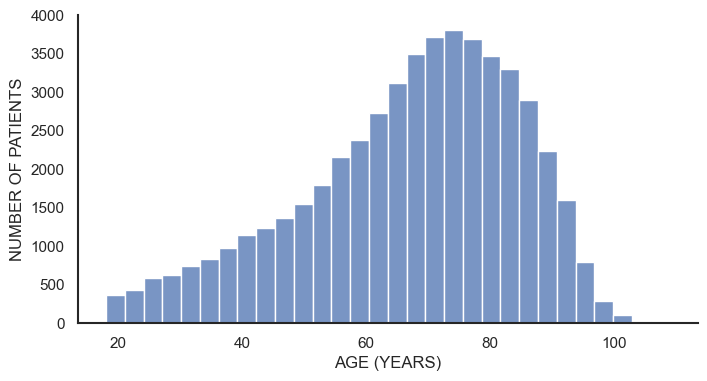

In [195]:
img = sns.histplot(data=df, x='age', fill=True, bins=30)
img.set_ylabel('NUMBER OF PATIENTS')
img.set_xlabel('AGE (YEARS)')
fig = img.get_figure()
fig.savefig('Age histogram.tiff', dpi=600, bbox_inches='tight')

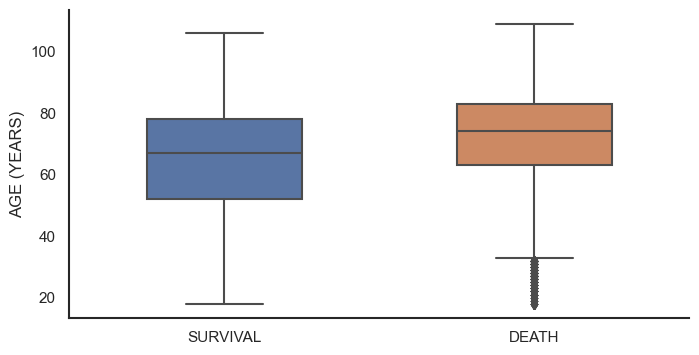

In [198]:
img = sns.boxplot(data=df, x='death', y='age', width=0.5)
img.set_ylabel('AGE (YEARS)')
img.set_xlabel(None)
img.set_xticklabels(['SURVIVAL', 'DEATH'])
fig = img.get_figure()
fig.savefig('Age boxplot.tiff', dpi=600, bbox_inches='tight')

In [163]:
df['age'].median()

70.0

In [164]:
df.groupby('death')['age'].median()

death
0    67.0
1    74.0
Name: age, dtype: float64

### Sex

In [165]:
male = df.groupby('male')['death'].value_counts().unstack()
male

death,0,1
male,,
0,16786,8731
1,15758,10241


### Race

In [166]:
race = df.groupby('race')['death'].value_counts().unstack()
race

death,0,1
race,,
asian,285,176
black,1659,1069
indigenous,34,32
mixed,8618,5225
white,21948,12470


### Education

In [167]:
ed = df.groupby('education')['death'].value_counts().unstack()
ed

death,0,1
education,,
illiterate,2687,2220
5_grade,10694,7447
9_grade,6457,3662
12_grade,8719,4016
higher_ed,3987,1627


In [168]:
dem_table = pd.concat([male, race, ed])
dem_table.to_excel('Demograpics_table.xlsx')
dem_table

death,0,1
0,16786,8731
1,15758,10241
asian,285,176
black,1659,1069
indigenous,34,32
mixed,8618,5225
white,21948,12470
illiterate,2687,2220
5_grade,10694,7447
9_grade,6457,3662


## Comorbidities

In [169]:
comorb_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
comorb_table_cont = pd.DataFrame(columns=['survival', 'death'])
select_comorb = []

for comorb in comorbidities: 
    cont_table = df.groupby(comorb)['death'].value_counts().unstack()
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    
    # Selecting the comorbidities for the training set: 
    if (odds_stat >= 1.20):
        select_comorb.append(comorb)

    comorb_table.loc[comorb, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    comorb_table.loc[comorb, 'pvalue'] = fisher
    cont_table.rename({0: 'survival', 1:'death'}, axis=1, inplace=True)
    cont_table.rename({0: f'no', 1: 'yes'}, axis=0, inplace=True)
    cont_table.reset_index(inplace=True)
    cont_table.rename({comorb:'presence'}, axis=1, inplace=True)
    cont_table.index = [comorb]*2
    comorb_table_cont = pd.concat([comorb_table_cont, cont_table])

comorb_table = comorb_table_cont.join(comorb_table)
comorb_table = comorb_table.reindex(['presence', 'survival', 'death', 'odds_ratio', 'pvalue'], axis=1).copy()
comorb_table.to_excel('Comorbidity_table.xlsx')
print(select_comorb)
comorb_table

['lung_disease', 'liver_disease', 'heart_disease', 'kidney_disease', 'blood_disease', 'neuro_disease']


,presence,survival,death,odds_ratio,pvalue
asthma,no,31009,18433,0.59 (0.53-0.65),<0.01
asthma,yes,1535,539,0.59 (0.53-0.65),<0.01
blood_disease,no,32083,18604,1.38 (1.2-1.58),<0.01
blood_disease,yes,461,368,1.38 (1.2-1.58),<0.01
diabetes,no,21310,11795,1.15 (1.11-1.2),<0.01
diabetes,yes,11234,7177,1.15 (1.11-1.2),<0.01
heart_disease,no,15896,8041,1.3 (1.25-1.35),<0.01
heart_disease,yes,16648,10931,1.3 (1.25-1.35),<0.01
kidney_disease,no,30604,16963,1.87 (1.75-2.0),<0.01
kidney_disease,yes,1940,2009,1.87 (1.75-2.0),<0.01


## Signs and Symptoms

In [170]:
symp_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
symp_table_cont = pd.DataFrame(columns=['survival', 'death'])
select_symp = []

for symp in signs_symptoms: 
    cont_table = df.groupby(symp)['death'].value_counts().unstack()
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)

    # Selecting the signs/symptos for the training set: 
    if (odds_stat >= 1.25):
        select_symp.append(symp)

    symp_table.loc[symp, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    symp_table.loc[symp, 'pvalue'] = fisher
    cont_table.rename({0: 'survival', 1:'death'}, axis=1, inplace=True)
    cont_table.rename({0: f'no', 1: 'yes'}, axis=0, inplace=True)
    cont_table.reset_index(inplace=True)
    cont_table.rename({symp:'presence'}, axis=1, inplace=True)
    cont_table.index = [symp]*2
    symp_table_cont = pd.concat([symp_table_cont, cont_table])

symp_table = symp_table_cont.join(symp_table)
symp_table = symp_table.reindex(['presence', 'survival', 'death', 'odds_ratio', 'pvalue'], axis=1).copy()
symp_table.to_excel('Symptoms_table.xlsx')
print(select_symp)
symp_table

['dyspnea', 'resp_discomfort', 'oxygen_saturation']


,presence,survival,death,odds_ratio,pvalue
abd_pain,no,29752,17591,0.84 (0.78-0.9),<0.01
abd_pain,yes,2792,1381,0.84 (0.78-0.9),<0.01
cough,no,8768,6744,0.67 (0.64-0.7),<0.01
cough,yes,23776,12228,0.67 (0.64-0.7),<0.01
diarrhea,no,28425,16833,0.88 (0.83-0.93),<0.01
diarrhea,yes,4119,2139,0.88 (0.83-0.93),<0.01
dyspnea,no,10872,3758,2.03 (1.95-2.12),<0.01
dyspnea,yes,21672,15214,2.03 (1.95-2.12),<0.01
fatigue,no,22064,13127,0.94 (0.9-0.97),<0.01
fatigue,yes,10480,5845,0.94 (0.9-0.97),<0.01


In [ ]:
fisher

# Machine Learning Models

In [171]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

In [172]:
# Converting variables into dummies 
race = pd.get_dummies(df['race'], drop_first=True)
education = pd.get_dummies(df['education'], drop_first=True)

In [173]:
features = (['age', 'male'] + list(race.columns) + list(education.columns) + 
            comorbidities + signs_symptoms)
features

['age',
 'male',
 'black',
 'indigenous',
 'mixed',
 'white',
 '5_grade',
 '9_grade',
 '12_grade',
 'higher_ed',
 'diabetes',
 'obesity',
 'lung_disease',
 'liver_disease',
 'heart_disease',
 'kidney_disease',
 'asthma',
 'blood_disease',
 'pregnancy',
 'neuro_disease',
 'fever',
 'cough',
 'sore_throat',
 'dyspnea',
 'resp_discomfort',
 'oxygen_saturation',
 'diarrhea',
 'vomiting',
 'abd_pain',
 'fatigue',
 'loss_smell',
 'loss_taste']

In [174]:
X1 = pd.concat([df, race, education], axis=1)
X1 = X1[features].copy()
X1 = X1.astype('uint8')
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51516 entries, 0 to 51515
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                51516 non-null  uint8
 1   male               51516 non-null  uint8
 2   black              51516 non-null  uint8
 3   indigenous         51516 non-null  uint8
 4   mixed              51516 non-null  uint8
 5   white              51516 non-null  uint8
 6   5_grade            51516 non-null  uint8
 7   9_grade            51516 non-null  uint8
 8   12_grade           51516 non-null  uint8
 9   higher_ed          51516 non-null  uint8
 10  diabetes           51516 non-null  uint8
 11  obesity            51516 non-null  uint8
 12  lung_disease       51516 non-null  uint8
 13  liver_disease      51516 non-null  uint8
 14  heart_disease      51516 non-null  uint8
 15  kidney_disease     51516 non-null  uint8
 16  asthma             51516 non-null  uint8
 17  blood_diseas

In [175]:
# Target variable
y1 = df['death']
y1 = y1.astype('uint8')
y1.info()

<class 'pandas.core.series.Series'>
RangeIndex: 51516 entries, 0 to 51515
Series name: death
Non-Null Count  Dtype
--------------  -----
51516 non-null  uint8
dtypes: uint8(1)
memory usage: 50.4 KB


In [176]:
# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 
                                                        y1, 
                                                        test_size=0.3,
                                                        random_state=42,
                                                        shuffle=True)

In [177]:
# Dataframe with the metrics from all the models:
df_models = pd.DataFrame()
df_models.index.name = 'Models'

In [187]:
# Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X1_train, y1_train)

y_pred = clf.predict(X1_test)
prob_pos = clf.predict_proba(X1_test)[:,1]

model_name = 'Decision Tree'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

# DOT data:
dot_data = export_graphviz(clf, out_file='tree.gv', 
                           feature_names=X1.columns,  
                           class_names={1:'death', 0:'survival'},
                           max_depth=3,
                           filled=True)

Decision Tree
Accuracy: 0.5753
Precision: 0.4256
Recall: 0.4167
F1 score: 0.4211
AUC: 0.5458


Decision Tree Visualization
- cd 'working_directory'
- dot -Tpng -Gdpi=300 tree.gv -o tree.tiff

In [188]:
# Random Forest

clf = RandomForestClassifier(random_state=42)
clf.fit(X1_train, y1_train)

y_pred = clf.predict(X1_test)
prob_pos = clf.predict_proba(X1_test)[:,1]

model_name = 'Random Forest'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Random Forest
Accuracy: 0.6332
Precision: 0.5071
Recall: 0.3694
F1 score: 0.4274
AUC: 0.6352


In [189]:
# Multilinear Perceptron

clf = MLPClassifier(random_state=42, hidden_layer_sizes=[5,4,2])
clf.fit(X1_train, y1_train)

y_pred = clf.predict(X1_test)
prob_pos = clf.predict_proba(X1_test)[:,1]

model_name = 'Multilinear Perceptron'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Multilinear Perceptron
Accuracy: 0.6635
Precision: 0.5569
Recall: 0.4511
F1 score: 0.4985
AUC: 0.6935


In [190]:
# K-Nearest Neighbors

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X1_train, y1_train)

y_pred = clf.predict(X1_test)
prob_pos = clf.predict_proba(X1_test)[:,1]

model_name = 'K-Nearest Neighbors'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

K-Nearest Neighbors
Accuracy: 0.6166
Precision: 0.4783
Recall: 0.3818
F1 score: 0.4247
AUC: 0.6042


In [191]:
# Logistic Regression

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X1_train, y1_train)

y_pred = clf.predict(X1_test)
prob_pos = clf.predict_proba(X1_test)[:,1]

model_name = 'Logistic Regression'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Logistic Regression
Accuracy: 0.6698
Precision: 0.5883
Recall: 0.3637
F1 score: 0.4495
AUC: 0.6927


In [192]:
# XGBoost

clf_xgboost = xgb.XGBClassifier()
clf_xgboost.fit(X1_train, y1_train)

y_pred = clf_xgboost.predict(X1_test)
prob_pos = clf_xgboost.predict_proba(X1_test)[:,1]

model_name = 'XGBoost'
print(model_name)

accuracy = accuracy_score(y1_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y1_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y1_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y1_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y1_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

XGBoost
Accuracy: 0.6574
Precision: 0.5577
Recall: 0.3650
F1 score: 0.4413
AUC: 0.6779


In [193]:
df_models.to_excel('Machine_learning_metrics.xlsx')
df_models

,Accuracy,Precision,Recall,F1 score,AUC
Models,,,,,
Decision Tree,0.5753,0.4256,0.4167,0.4211,0.5458
Random Forest,0.6332,0.5071,0.3694,0.4274,0.6352
Multilinear Perceptron,0.6635,0.5569,0.4511,0.4985,0.6935
K-Nearest Neighbors,0.6166,0.4783,0.3818,0.4247,0.6042
Logistic Regression,0.6698,0.5883,0.3637,0.4495,0.6927
XGBoost,0.6574,0.5577,0.3650,0.4413,0.6779


## Specific Models

### Age > 65

In [ ]:
sns.histplot(data=df, x='age', hue='death', bins=15)

In [ ]:
# age > 65
df_age = df[(df['age'] > 65)].copy()
df_age.index = pd.RangeIndex(start=0, stop=len(df_age.index))
df_age.info()

In [ ]:
sns.histplot(data=df_age, x='age', hue='death', bins=15)

In [ ]:
# features.remove('age')
X2 = df_age[features].copy()
X2 = X2.astype('uint8')
X2.info()

In [ ]:
# Target variable
y2 = df_age['death']
y2 = y2.astype('uint8')
y2.info()

In [ ]:
# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.3,
                                                        random_state=42,
                                                        shuffle=True)

In [ ]:
# Decision Tree
clf_dt = DecisionTreeClassifier(random_state=42, max_depth=6)
clf_dt.fit(X2_train, y2_train)
y_pred = clf_dt.predict(X2_test)
print(classification_report(y2_test, y_pred))

# Decision Tree Visualization
# DOT data:
dot_data = export_graphviz(clf_dt, out_file='tree.gv', 
                           feature_names=X2.columns,  
                           class_names={1:'Obito', 0:'Cura'},
                           filled=True)

#### Run command line ####
# cd 'MBA DSA/4 - TCC/COVID-19 Brazil Data'
# dot -Tpng -Gdpi=300 tree_filtered_age.gv -o tree.tiff

In [ ]:
# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X2_train, y2_train)
y_pred = clf_rf.predict(X2_test)
print(classification_report(y2_test, y_pred))

### Non-vaccinated

In [ ]:
df_nvac = df[df['first_dose'] == 0].copy()
df_nvac.index = pd.RangeIndex(0, len(df_nvac.index))
df_nvac

In [ ]:
X3 = df_nvac[features].copy()
X3 = X3.astype('uint8')
X3.info()

In [ ]:
y3 = df_nvac['death']
y3 = y3.astype('uint8')
y3

In [ ]:
# Train-test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, 
                                                        y3, 
                                                        test_size=0.3,
                                                        random_state=42,
                                                        shuffle=True)

In [ ]:
# Decision Tree
clf_dt = DecisionTreeClassifier(random_state=42, max_depth=6)
clf_dt.fit(X3_train, y3_train)
y_pred = clf_dt.predict(X3_test)
print(classification_report(y3_test, y_pred))

# Decision Tree Visualization
# DOT data:
dot_data = export_graphviz(clf_dt, out_file='tree.gv', 
                           feature_names=X2.columns,  
                           class_names={1:'Obito', 0:'Cura'},
                           filled=True)

#### Run command line ####
# cd 'MBA DSA/4 - TCC/COVID-19 Brazil Data'
# dot -Tpng -Gdpi=300 tree_filtered_nvac.gv -o tree.tiff

In [ ]:
# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X3_train, y3_train)
y_pred = clf_rf.predict(X3_test)
print(classification_report(y3_test, y_pred))

In [ ]:
def extract(array, i):
    if i > 1:
        return None
    return [item[i] for item in array]

proba_death = extract(clf2.predict_proba(X1_test), 1)
proba_survi = extract(clf2.predict_proba(X1_test), 0)

In [ ]:
from scipy import stats

In [ ]:
from scipy.stats.contingency import odds_ratio